In [56]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.express as px
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modelling and Forecasting
# ==============================================================================
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

In [57]:
#Reading in data
# ==============================================================================
building1=pd.read_csv('Building 1.csv')

In [58]:
#Converting to Datetime objects
# ==============================================================================
building1['datetime']=pd.to_datetime(building1['datetime'], format='%Y-%m-%d %H:%M:%S')
building1= building1.set_index('datetime')
building1= building1.asfreq('H')

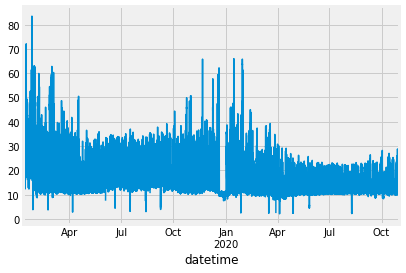

In [59]:
building1['series_value'].plot()

In [60]:
#Further Split Train-Val for Buildings
# ==============================================================================
end_train='2020-04-01 00:00'
start_val='2020-04-01 01:00'
end_val='2020-07-01 00:00'
start_test='2020-07-01 01:00'


building1train=building1.loc[:end_train, :]
building1val=building1.loc[start_val:end_val, :]
building1test=building1.loc[start_test:, :]


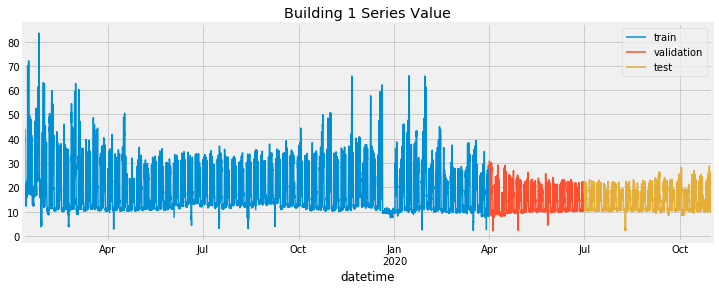

In [61]:
# Plot time series
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
building1train['series_value'].plot(ax=ax, label='train')
building1val['series_value'].plot(ax=ax, label='validation')
building1test['series_value'].plot(ax=ax, label='test')
ax.set_title('Building 1 Series Value')
ax.legend();

In [62]:
building1=building1.dropna()

In [63]:
# Create LightGBM forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = LGBMRegressor(random_state=123),
                lags = 24
                )

forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window size: 24 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 
Creation date: 2022-09-24 13:46:51 
Last fit date: None 
Skforecast version: 0.4.3 

In [64]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters

param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
    }
lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = building1.loc[:end_val, 'series_value'],
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(building1train)),
                        lags_grid          = lags_grid,
                        param_grid         = param_grid,
                        steps              = 36,
                        )

Number of models compared: 48


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

loop param_grid:  50%|██████████████████▌                  | 6/12 [00:04<00:05,  1.19it/s]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

loop param_grid:  83%|██████████████████████████████      | 10/12 [00:06<00:01,  1.45it/s]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

loop param_grid:  50%|██████████████████▌                  | 6/12 [00:05<00:06,  1.13s/it]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

loop param_grid:  83%|██████████████████████████████      | 10/12 [00:08<00:01,  1.15it/s]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '

loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

loop param_grid:  33%|████████████▎                        | 4/12 [00:03<00:08,  1.09s/it]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '

loop param_grid:  25%|█████████▎                           | 3/12 [00:01<00:05,  1.54it/s]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '

loop param_grid:  50%|██████████████████▌                  | 6/12 [00:04<00:05,  1.18it/s]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` ha

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '

loop param_grid:  67%|████████████████████████▋            | 8/12 [00:05<00:03,  1.32it/s]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` ha

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500}
  Backtesting metric: 18.15545402124101



In [65]:
# Results of grid search
# ==============================================================================
results_grid.head(10)

lags  \
35  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
33  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
34  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
31  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
27  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
29  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
32  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
43                  [1, 2, 3, 23, 24, 25, 71, 72, 73]   
42                  [1, 2, 3, 23, 24, 25, 71, 72, 73]   
37                  [1, 2, 3, 23, 24, 25, 71, 72, 73]   

                                               params     metric  \
35  {'learning_rate': 0.1, 'max_depth': 10, 'n_est...  18.155454   
33  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...  18.989089   
34  {'learning_rate': 0.1, 'max_depth': 10, 'n_est...  19.155265   
31  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...  19.526143   
27  {'learning_rate': 0.01, 'max_depth': 5, 'n_est...  19.754144   
29  {'learning_rate': 0.01, 'max_depth': 10, 'n_es...  21.101295   
32  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...  21.188032   
43  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...  22.202889   
42  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...  24.378438   
37  {'learning_rate': 0.01, 'max_depth': 3, 'n_est...  26.155728   

    learning_rate  max_depth  n_estimators  
35           0.10       10.0         500.0  
33           0.10        5.0         500.0  
34           0.10       10.0         100.0  
31           0.10        3.0         500.0  
27           0.01        5.0         500.0  
29           0.01       10.0         500.0  
32           0.10        5.0         100.0  
43           0.10        3.0         500.0  
42           0.10        3.0         100.0  
37           0.01        3.0         500.0

In [66]:
# Backtesting
# ==============================================================================
metric, predictions = backtesting_forecaster(
    forecaster = forecaster,
    y          = building1['series_value'],
    initial_train_size = len(building1.loc[:end_val]),
    fixed_train_size   = False,
    steps      = 36,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False
    )

print(f"Backtest error: {metric}")

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Backtest error: 5.43526843174772


C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

In [67]:
# Predictions
# ==============================================================================
predictions

pred
72   18.635198
73   18.719112
74   19.085467
75   19.089840
76   19.264823
..         ...
101  14.840990
102  15.497661
103  17.180237
104  17.805416
105  19.299773

[2950 rows x 1 columns]

In [68]:
from sklearn.metrics import mean_absolute_error

def mean_absolute_scaled_error(y_true, y_pred, y_train):
    e_t = y_true - y_pred
    scale = mean_absolute_error(y_train[1:], y_train[:-1])
    return np.mean(np.abs(e_t / scale))

In [70]:
LightGBM_MASE=mean_absolute_scaled_error(building1test.dropna().reset_index()['series_value'],predictions['pred'],building1train.dropna().reset_index()['series_value'])

In [ ]:
# CatBoost Forecasting
# ==============================================================================

In [71]:
# Create Catboost forecaster
# ==============================================================================
cat_forecaster = ForecasterAutoreg(
                regressor = CatBoostRegressor(random_state=123, silent=True),
                lags = 24
                )

cat_forecaster

ForecasterAutoreg 
Regressor: <catboost.core.CatBoostRegressor object at 0x000001E74E6DDF28> 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window size: 24 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'loss_function': 'RMSE', 'silent': True, 'random_state': 123} 
Creation date: 2022-09-24 13:48:50 
Last fit date: None 
Skforecast version: 0.4.3 

In [72]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters

param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
    }
lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

results_grid = grid_search_forecaster(
                        forecaster         = cat_forecaster,
                        y                  = building1.loc[:end_val, 'series_value'],
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(building1train)),
                        lags_grid          = lags_grid,
                        param_grid         = param_grid,
                        steps              = 36,
                        )

Number of models compared: 48


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

loop param_grid:  67%|████████████████████████▋            | 8/12 [01:05<00:36,  9.01s/it]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

loop param_grid:  25%|█████████▎                           | 3/12 [00:10<00:30,  3.43s/it]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

loop param_grid:  67%|████████████████████████▋            | 8/12 [02:00<01:09, 17.34s/it]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

loop param_grid:  33%|████████████▎                        | 4/12 [00:21<00:48,  6.04s/it]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

loop param_grid:  42%|███████████████▍                     | 5/12 [00:47<01:33, 13.36s/it]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

loop param_grid:  50%|██████████████████▌                  | 6/12 [02:33<04:28, 44.79s/it]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

loop param_grid:  25%|█████████▎                           | 3/12 [00:06<00:19,  2.14s/it]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

loop param_grid:  50%|██████████████████▌                  | 6/12 [00:31<00:49,  8.21s/it]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

loop param_grid:  58%|█████████████████████▌               | 7/12 [00:33<00:30,  6.14s/it]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

loop param_grid:  83%|██████████████████████████████      | 10/12 [00:41<00:07,  3.67s/it]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

loop lags_grid: 100%|██████████████████████████████████████| 4/4 [11:40<00:00, 175.08s/it]
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500}
  Backtesting metric: 15.496573322789816



In [74]:
# Backtesting
# ==============================================================================
metric, cat_predictions = backtesting_forecaster(
    forecaster = cat_forecaster,
    y          = building1['series_value'],
    initial_train_size = len(building1.loc[:end_val]),
    fixed_train_size   = False,
    steps      = 36,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False
    )

print(f"Backtest error: {metric}")

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Backtest error: 6.198959211326876


C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

In [75]:
CatBoost_MASE=mean_absolute_scaled_error(building1test.dropna().reset_index()['series_value'],cat_predictions['pred'],building1train.dropna().reset_index()['series_value'])

In [76]:
# Create XGB forecaster
# ==============================================================================
XGB_forecaster = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=123),
                lags = 24
                )

XGB_forecaster

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=123,
             reg_alpha=None, reg_lambda=None, ...) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window size: 24 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 

In [77]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters

param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
    }
lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

results_grid = grid_search_forecaster(
                        forecaster         = XGB_forecaster,
                        y                  = building1.loc[:end_val, 'series_value'],
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(building1train)),
                        lags_grid          = lags_grid,
                        param_grid         = param_grid,
                        steps              = 36,
                        )

Number of models compared: 48


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

loop param_grid:  17%|██████▏                              | 2/12 [00:06<00:30,  3.08s/it]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

loop param_grid:  25%|█████████▎                           | 3/12 [00:08<00:25,  2.86s/it]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

loop param_grid:  33%|████████████▎                        | 4/12 [00:12<00:27,  3.42s/it]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

loop param_grid:  58%|█████████████████████▌               | 7/12 [00:27<00:21,  4.29s/it]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

loop param_grid:  83%|██████████████████████████████      | 10/12 [00:37<00:07,  3.65s/it]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

loop param_grid:  17%|██████▏                              | 2/12 [00:06<00:33,  3.36s/it]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

loop param_grid:  33%|████████████▎                        | 4/12 [00:15<00:33,  4.22s/it]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

loop param_grid:  42%|███████████████▍                     | 5/12 [00:19<00:28,  4.12s/it]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

loop param_grid:  67%|████████████████████████▋            | 8/12 [00:39<00:20,  5.22s/it]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:42<00:13,  4.46s/it]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

loop param_grid:  83%|██████████████████████████████      | 10/12 [00:48<00:09,  4.87s/it]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:52<00:04,  4.72s/it]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

loop param_grid:   8%|███                                  | 1/12 [00:02<00:29,  2.71s/it]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

loop param_grid:  25%|█████████▎                           | 3/12 [00:10<00:32,  3.62s/it]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

loop param_grid:  58%|█████████████████████▌               | 7/12 [00:45<00:37,  7.53s/it]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

loop param_grid:  67%|████████████████████████▋            | 8/12 [00:49<00:26,  6.62s/it]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:52<00:16,  5.51s/it]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

loop param_grid:  83%|██████████████████████████████      | 10/12 [00:59<00:11,  5.89s/it]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

loop param_grid:  92%|█████████████████████████████████   | 11/12 [01:04<00:05,  5.67s/it]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

loop param_grid:  33%|████████████▎                        | 4/12 [00:10<00:22,  2.79s/it]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

loop param_grid:  42%|███████████████▍                     | 5/12 [00:13<00:19,  2.74s/it]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

loop param_grid:  50%|██████████████████▌                  | 6/12 [00:19<00:22,  3.77s/it]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

loop param_grid:  58%|█████████████████████▌               | 7/12 [00:21<00:16,  3.26s/it]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 15.223739082835896



In [79]:
# Backtesting
# ==============================================================================
metric, XGB_predictions = backtesting_forecaster(
    forecaster = XGB_forecaster,
    y          = building1['series_value'],
    initial_train_size = len(building1.loc[:end_val]),
    fixed_train_size   = False,
    steps      = 36,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False
    )

print(f"Backtest error: {metric}")

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Backtest error: 6.669198855662554


C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '


In [80]:
XGB_MASE=mean_absolute_scaled_error(building1test.dropna().reset_index()['series_value'],XGB_predictions['pred'],building1train.dropna().reset_index()['series_value'])

In [101]:
#Using Prophet into LightGBM
# ==============================================================================
prophet=pd.read_csv('b1_actual_additive.csv')

In [97]:
prophet

datetime  subtraction  additive_terms  actual_value
0      2019-01-10 00:00:00    22.725116        9.974884          32.7
1      2019-01-10 01:00:00    23.480135       11.019865          34.5
2      2019-01-10 02:00:00    20.887312       11.612688          32.5
3      2019-01-10 03:00:00    20.820963       12.179037          33.0
4      2019-01-10 04:00:00    25.820065       12.779935          38.6
...                    ...          ...             ...           ...
15836  2020-10-31 19:00:00    24.100499      -13.500499          10.6
15837  2020-10-31 20:00:00    21.748621      -11.848621           9.9
15838  2020-10-31 21:00:00    20.614613       -9.814613          10.8
15839  2020-10-31 22:00:00    17.209272       -7.409272           9.8
15840  2020-10-31 23:00:00    16.271974       -4.971974          11.3

[15841 rows x 4 columns]

In [102]:
#Converting to Datetime objects
# ==============================================================================
prophet['datetime']=pd.to_datetime(prophet['datetime'], format='%Y-%m-%d %H:%M:%S')
prophet= prophet.set_index('datetime')
prophet= prophet.asfreq('H')

In [103]:
prophet

subtraction  additive_terms  actual_value
datetime                                                      
2019-01-10 00:00:00    22.725116        9.974884          32.7
2019-01-10 01:00:00    23.480135       11.019865          34.5
2019-01-10 02:00:00    20.887312       11.612688          32.5
2019-01-10 03:00:00    20.820963       12.179037          33.0
2019-01-10 04:00:00    25.820065       12.779935          38.6
...                          ...             ...           ...
2020-10-31 19:00:00    24.100499      -13.500499          10.6
2020-10-31 20:00:00    21.748621      -11.848621           9.9
2020-10-31 21:00:00    20.614613       -9.814613          10.8
2020-10-31 22:00:00    17.209272       -7.409272           9.8
2020-10-31 23:00:00    16.271974       -4.971974          11.3

[15864 rows x 3 columns]

In [105]:
prophettrain=prophet.loc[:end_train, :]
prophetval=prophet.loc[start_val:end_val, :]
prophettest=prophet.loc[start_test:, :]

In [108]:
prophet=prophet.dropna()

In [109]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters

param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
    }
lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = prophet.loc[:end_val, 'subtraction'],
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(prophettrain)),
                        lags_grid          = lags_grid,
                        param_grid         = param_grid,
                        steps              = 36,
                        )

Number of models compared: 48


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '



----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 2020-04-09 10:00:00
Data partition i

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '

loop param_grid:  17%|██████▏                              | 2/12 [00:01<00:06,  1.45it/s]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarni

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

loop param_grid:  33%|████████████▎                        | 4/12 [00:02<00:06,  1.23it/s]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

loop param_grid:  67%|████████████████████████▋            | 8/12 [00:06<00:03,  1.11it/s]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '

loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:08<00:00,  1.25it/s]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarni

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '

loop param_grid:  67%|████████████████████████▋            | 8/12 [00:08<00:04,  1.06s/it]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarni

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:10<00:00,  1.03it/s]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

loop param_grid:  17%|██████▏                              | 2/12 [00:01<00:09,  1.08it/s]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '

loop param_grid:  50%|██████████████████▌                  | 6/12 [00:07<00:08,  1.49s/it]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:10<00:02,  1.10s/it]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '

loop param_grid:  50%|██████████████████▌                  | 6/12 [00:03<00:04,  1.36it/s]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` ha

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10729
Number of observations used for backtesting: 2162
    Number of folds: 61
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-01 23:00:00 -- 2020-04-03 10:00:00
Data partition in fold: 1
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-03 11:00:00 -- 2020-04-04 22:00:00
Data partition in fold: 2
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-04 23:00:00 -- 2020-04-06 10:00:00
Data partition in fold: 3
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-06 11:00:00 -- 2020-04-07 22:00:00
Data partition in fold: 4
    Training:   2019-01-10 00:00:00 -- 2020-04-01 22:00:00
    Validation: 2020-04-07 23:00:00 -- 20

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '

loop lags_grid: 100%|███████████████████████████████████████| 4/4 [00:44<00:00, 11.19s/it]
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 12.784069229863483



In [110]:
# Results of grid search
# ==============================================================================
results_grid.head(10)

lags  \
33  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
35  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
31  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
19  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
23  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
32  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
34  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
44                  [1, 2, 3, 23, 24, 25, 71, 72, 73]   
21  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
41                  [1, 2, 3, 23, 24, 25, 71, 72, 73]   

                                               params     metric  \
33  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...  12.784069   
35  {'learning_rate': 0.1, 'max_depth': 10, 'n_est...  12.987043   
31  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...  15.844623   
19  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...  15.893132   
23  {'learning_rate': 0.1, 'max_depth': 10, 'n_est...  16.158416   
32  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...  16.350308   
34  {'learning_rate': 0.1, 'max_depth': 10, 'n_est...  16.439747   
44  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...  17.488686   
21  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...  17.643711   
41  {'learning_rate': 0.01, 'max_depth': 10, 'n_es...  17.649082   

    learning_rate  max_depth  n_estimators  
33           0.10        5.0         500.0  
35           0.10       10.0         500.0  
31           0.10        3.0         500.0  
19           0.10        3.0         500.0  
23           0.10       10.0         500.0  
32           0.10        5.0         100.0  
34           0.10       10.0         100.0  
44           0.10        5.0         100.0  
21           0.10        5.0         500.0  
41           0.01       10.0         500.0

In [113]:
# Backtesting
# ==============================================================================
metric, prophet_predictions = backtesting_forecaster(
    forecaster = forecaster,
    y          = prophet['subtraction'],
    initial_train_size = len(prophet.loc[:end_val]),
    fixed_train_size   = False,
    steps      = 36,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False # Change to True to see detailed information
    )

print(f"Backtest error: {metric}")

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Backtest error: 5.089071989920691


C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

In [114]:
# Predictions
# ==============================================================================
prophet_predictions

pred
72    9.759838
73    8.988887
74    8.433468
75    8.571864
76    8.518590
..         ...
101  20.090522
102  18.284418
103  16.223908
104  14.252365
105  13.196649

[2950 rows x 1 columns]

In [130]:
prophet_predictions_final=prophet_predictions.reset_index()['pred']+prophet.loc[start_test:, :].reset_index()['additive_terms']

In [137]:
prophettest=prophettest.dropna()
prophettrain=prophettrain.dropna()

In [138]:
LightGBM_Prophet_MASE=mean_absolute_scaled_error(prophettest.reset_index()['subtraction'],prophet_predictions_final,prophettrain.reset_index()['subtraction'])

In [139]:
LightGBM_Prophet_MASE

3.6604603401146227

In [142]:
LightGBM_MASE

2.5053999822964297

In [140]:
CatBoost_MASE

2.498632398519796

In [141]:
XGB_MASE

2.3126068403336824